<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/kmeans_deep_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How it differs from the default solution? 

More smaller patches and denser patches extraction from images.

    PATCH_SIZE = 4
    patch_num  = 5000000
    STRIDE     = 2
    
Also, more clustsers:

    kroot = 32
    k = kroot * kroot
    
Note that it takes significant time to execute all steps

# Load data & default imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats as sstats
from sklearn import datasets
import sklearn.linear_model
from tqdm.auto import tqdm
from matplotlib import animation, pyplot, rc
import matplotlib.pyplot as plt
import httpimport
from PIL import Image

In [2]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz

In [3]:
with np.load('cifar.npz') as data:
    cifar_train_data = data['train_data']
    cifar_train_labels = data['train_labels']
    cifar_test_data = data['test_data']
    cifar_test_labels = data['test_labels']



In [4]:
X_trn = cifar_train_data
y_trn = cifar_train_labels
X_tst = cifar_test_data
y_tst = cifar_test_labels

# Deep Features

## find important patterns in patches

In [5]:
def contrast(image):
    return (image-image.min())/(image.max() - image.min())

def normalize_patch(patch, eps=10):
    return (patch - patch.mean())/np.sqrt(patch.var() + eps)

def whiten(X):
    X_norm = (X - X.mean(axis=0))/X.std(axis=0)
    cov = np.cov(X_norm, rowvar=False) 
    U,S,V = np.linalg.svd(cov)

    X_zca = U.dot(np.diag(1.0/np.sqrt(S + 0.1))).dot(U.T).dot(X_norm.T).T
    return X_zca

In [6]:
PATCH_SIZE = 4        # SMALLLER PATCHES
patch_num  = 5000000  # MORE PATCHES
STRIDE     = 2        # SMALLER STRIDE, THEREFORE MORE DENSE COVER

In [7]:
patches = []

X_trn_reshaped = X_trn.reshape(-1,32,32,3)

n = int(patch_num / (32-PATCH_SIZE+1) ** 2 + 1)

for i in tqdm(range(n)):
    for r in range(32-PATCH_SIZE+1):
        for c in range(32-PATCH_SIZE+1):
            patch = X_trn_reshaped[i][c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)].flatten()
            patch_norm = normalize_patch(patch, eps=10)
            patches.append(patch_norm)

  0%|          | 0/5946 [00:00<?, ?it/s]

In [8]:
P = np.vstack(patches)
P_zca = whiten(P)

# Clusters

In [9]:
kroot = 32
k = kroot*kroot

In [10]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, verbose=False, n_init=1, max_iter=200, batch_size=10000)
kmeans.fit(P_zca)
filters_final = kmeans.cluster_centers_

# Some intuition what the patches are

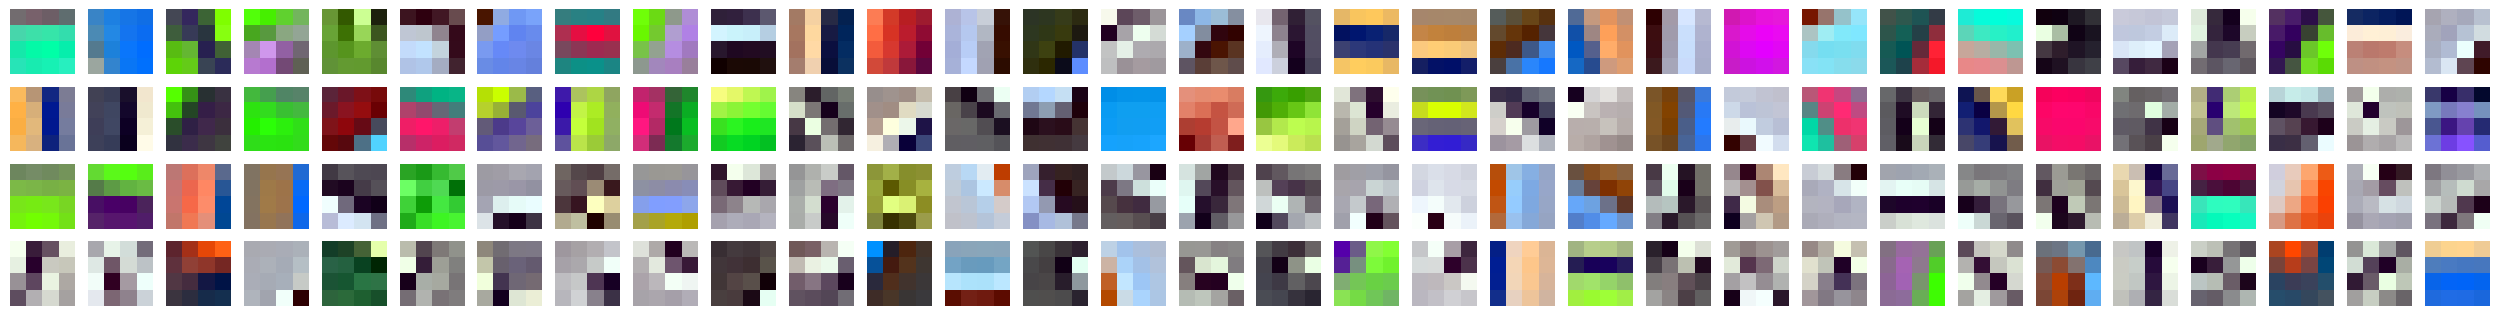

In [11]:
plt.figure(figsize=(kroot,kroot))
for xx in range(128):
    plt.subplot(kroot,kroot,xx+1)
    plt.imshow((contrast(filters_final[xx])).reshape(PATCH_SIZE, PATCH_SIZE, 3))
    plt.axis('off')
    

# Transform dataset according to the patterns found in patches




In [12]:
def dist(x,y):
    return np.sqrt((x - y).dot(x-y))

def create_patch_features(X):    
    X_mapped_list_per_image = []
    for i in tqdm(range(X.shape[0])):
        mapped_features = []
        for r in range(0, 32-PATCH_SIZE+1, STRIDE):
            for c in range(0, 32-PATCH_SIZE+1, STRIDE):
                patch = X[i].reshape(32,32,3)[c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)].flatten()
                patch_norm = normalize_patch(patch, eps=0.01)
                mapped_features.append([dist(patch_norm, f) for f in filters_final])
        X_mapped_list_per_image.append(np.vstack(mapped_features))
    X_mapped = np.asarray(X_mapped_list_per_image).reshape(-1, ((32-PATCH_SIZE)//STRIDE+1)**2*filters_final.shape[0])
    return X_mapped


In [13]:
from sklearn.feature_extraction import image
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

def create_patch_features__vectorized(X):    
    X_mapped_list_per_image = []
    for i in tqdm(range(X.shape[0])):
        patches = image.extract_patches_2d(X[i], (PATCH_SIZE, PATCH_SIZE))
        strided_patches = patches.reshape( 32-PATCH_SIZE+1 , 32-PATCH_SIZE+1, PATCH_SIZE, PATCH_SIZE, 3)[::STRIDE,::STRIDE,:,:,:]
        strided_patches = strided_patches.reshape(((32-PATCH_SIZE)//STRIDE+1)**2, PATCH_SIZE * PATCH_SIZE * 3)
        mapped_features = euclidean_distances(np.asarray([normalize_patch(patch, eps=0.01) for patch in strided_patches]), filters_final)
        X_mapped_list_per_image.append(mapped_features.reshape(((32-PATCH_SIZE)//STRIDE+1)**2 * filters_final.shape[0]))
    X_mapped = np.asarray(X_mapped_list_per_image)
    return X_mapped

In [ ]:
X_mapped_trn = create_patch_features__vectorized(X_trn)
X_mapped_tst = create_patch_features__vectorized(X_tst)

  0%|          | 0/50000 [00:00<?, ?it/s]

# Logistic Regression on mapped features

In [ ]:
X_mapped_trn_norm = (X_mapped_trn - X_mapped_trn.mean(axis=0))/X_mapped_trn.std(axis=0)
X_mapped_tst_norm = (X_mapped_tst - X_mapped_trn.mean(axis=0))/X_mapped_trn.std(axis=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=10, n_jobs=-1, verbose=False).fit(X_mapped_trn_norm, y_trn.flatten())

# Results! 😊

In [ ]:
y_trn_pred = clf.predict(X_mapped_trn_norm)
print(f"Train: {(y_trn.flatten() == y_trn_pred).mean()}")

y_tst_pred = clf.predict(X_mapped_tst_norm)
print(f"Test:  {(y_tst.flatten() == y_tst_pred).mean()}")
